In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import glob

In [3]:
def avantes_aggregator(filepath,fileout):
    """ Aggregates Avantes ASCII 2D spectra takes the log folder (avantes generated) and the name
    (with path) of the output npy """
    files = glob.glob(filepath+'*.TXT')
    #print(files)
    for ii,filename in enumerate(files):
        counts = []
        if ii==0:
            wavelength = []
            with open(filename) as file:
                lineas=file.readlines()
                lineas=lineas[8:-2]
            for line in lineas:
                lines=line.split(';')
                wavelength.append(float(lines[0]))
                counts.append(float(lines[1]))
            spectra=np.concatenate((np.array(wavelength,ndmin=2).T,np.array(counts,ndmin=2).T),axis=1)
        else:
            with open(filename) as file:
                lineas=file.readlines()
                lineas=lineas[8:-2]
            for line in lineas:
                lines=line.split(';')
                counts.append(float(lines[1]))
            spectra=np.concatenate((spectra,np.array(counts,ndmin=2).T),axis=1)
    np.save(fileout,spectra)

def spectra_accumulator(npyin,samples,verbose=0):
    """ Accumulates a number of samples from the single spectrum npy matrix """
    ceaspec = np.load(npyin)
    cols=len(ceaspec[0,:])

    fromcol = 1
    tocol = fromcol + samples
    accum=np.copy(ceaspec[:,0]).reshape(len(ceaspec[:,0]),1)

    while tocol<=cols:
        #print(fromcol,tocol)
        suma=np.sum(ceaspec[:,fromcol:tocol],axis=1,keepdims=1)
        accum=np.concatenate((accum,suma),axis=1)
        tocol=tocol+samples
        fromcol=fromcol+samples
    if verbose==1:
        print(accum.shape)
    return accum

def extinction(I_sample, I_0, Reff, distance):
    "Calculates extinction spectrum"
    I_ratio=(I_0/I_sample)
    return (1/distance)*(I_ratio-1)*(1-Reff)

In [24]:
##### Spectra handling

In [4]:
## Load files into matrices
logfolder1 = 'D:\\CCA\\Avantes\\logs30nov10H\\'
#logfolder1 = '/home/mixtli/Avantes/logs30nov/'
#logfolder2 = 'D:\\OneDrive\\CCA\\CEAS\\AvantesLogs\\logs11nov\\'
#DCbg1=np.load(logfolder1 + 'CEASbckg1DC.npy')
#DCbg2=np.load(logfolder1 + 'CEASbckg2DC.npy')
#DCln1=np.load(logfolder1 + 'CEASline1DC.npy')

SCbg1 = spectra_accumulator(logfolder1 + 'CEASbckg1SC1.npy',20)
SCbg2 = spectra_accumulator(logfolder1 + 'CEASbckg2SC1.npy',20)
#SCln1 = spectra_accumulator(logfolder1 + 'CEASline1SC1.npy',20)

#nov11bg1a = spectra_accumulator(logfolder2 + 'CEASbckg1.npy',10)
#nov11bg2a = spectra_accumulator(logfolder2 + 'CEASbckg2.npy',10)
#nov11ln1a = spectra_accumulator(logfolder2 + 'CEASline1.npy',10)
#nov4bg1b = spectra_accumulator(logfolder1 + 'CEASbckg1.npy',20)
#nov4bg2b = spectra_accumulator(logfolder1 + 'CEASbckg2.npy',20)
#nov4ln1b = spectra_accumulator(logfolder1 + 'CEASline1.npy',20)
#nov11bg1b = spectra_accumulator(logfolder2 + 'CEASbckg1.npy',20)
#nov11bg2b = spectra_accumulator(logfolder2 + 'CEASbckg2.npy',20)
#nov11ln1b = spectra_accumulator(logfolder2 + 'CEASline1.npy',20)

In [5]:
## Extinction
line=SCln1
bckg=SCbg2
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha1 = extinction(I_sample,I_0,0.99985,70)

line=SCln1
bckg=SCbg1
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha2 = extinction(I_sample,I_0,0.99985,70)

NameError: name 'SCln1' is not defined

In [6]:
## Extinction of backgrounds
line=SCbg1
bckg=SCbg2
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha1 = extinction(I_sample,I_0,0.99985,70)

line=SCbg2
bckg=SCbg1
I_sample=np.average(line[:,1:],axis=1)
I_0=np.average(bckg[:,1:],axis=1)
alpha2 = extinction(I_sample,I_0,0.99985,70)

In [83]:
## Extinction (single spectrum)
I_sample=nov4ln1b[:,1]
I_0=nov4bg2b[:,1]
alpha1 = extinction(I_sample,I_0,0.99985,70)

I_sample=nov11ln1b[:,15]
I_0=nov11bg2b[:,15]
alpha2 = extinction(I_sample,I_0,0.99985,70)

In [ ]:
##### Spectra plotting

In [ ]:
## Single plot of accumulations
spectra = nov11bg2b
cols=len(spectra[0,:])
col = 1

f, ax0 = plt.subplots(figsize=(14,6))

while col < cols:
    ax0.plot(spectra[:,0],spectra[:,col])
    col = col+1

## Formatting 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax0.set_xlim(440,464)
ax0.set_xticks(np.arange(440,466,2))
ax0.set_xlabel('Wavelength',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Counts',size=14)
ax0.set_title("BBCEAS Accumulations",size=16)
#ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
#ax0.text(0.05, 0.95, 'Accumulations', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)

Text(0.05, 0.65, 'N=60')

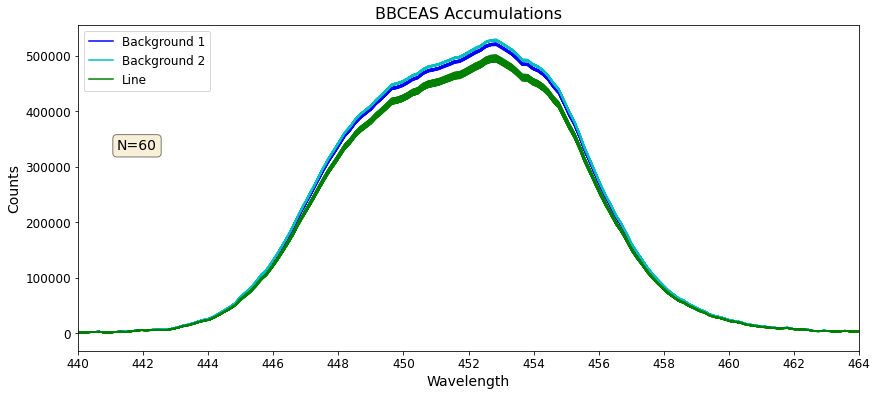

In [8]:
## Single plot of comparison of accumulations
f, ax0 = plt.subplots(figsize=(14,6))

spectra = SCbg1 
cols=len(spectra[0,:]) 
col = 2

ax0.plot(spectra[:,0],spectra[:,1],'-b',label="Background 1")

while col < cols: 
    ax0.plot(spectra[:,0],spectra[:,col],'-b') 
    col = col+1

spectra = SCbg2
cols=len(spectra[0,:]) 
col = 2

ax0.plot(spectra[:,0],spectra[:,1],'-c',label="Background 2")

while col < cols: 
    ax0.plot(spectra[:,0],spectra[:,col],'-c') 
    col = col+1

spectra = SCln1 
cols=len(spectra[0,:]) 
col = 2

ax0.plot(spectra[:,0],spectra[:,1],'-g',label="Line")

while col < cols: 
    ax0.plot(spectra[:,0],spectra[:,col],'-g') 
    col = col+1

#spectra = nov11ln1b 
#cols=len(spectra[0,:]) 
#col = 2
#
#ax0.plot(spectra[:,0],spectra[:,1],'-r',label="Line Nov 11")
#
#while col < cols: 
#    ax0.plot(spectra[:,0],spectra[:,col],'-r') 
#    col = col+1
#
## Formatting 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax0.set_xlim(440,464)
ax0.set_xticks(np.arange(440,466,2))
ax0.set_xlabel('Wavelength',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Counts',size=14)
ax0.set_title("BBCEAS Accumulations",size=16)
ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.text(0.05, 0.65, 'N=60', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASaccums.png')

Text(0.05, 0.95, 'StDev (N=30)')

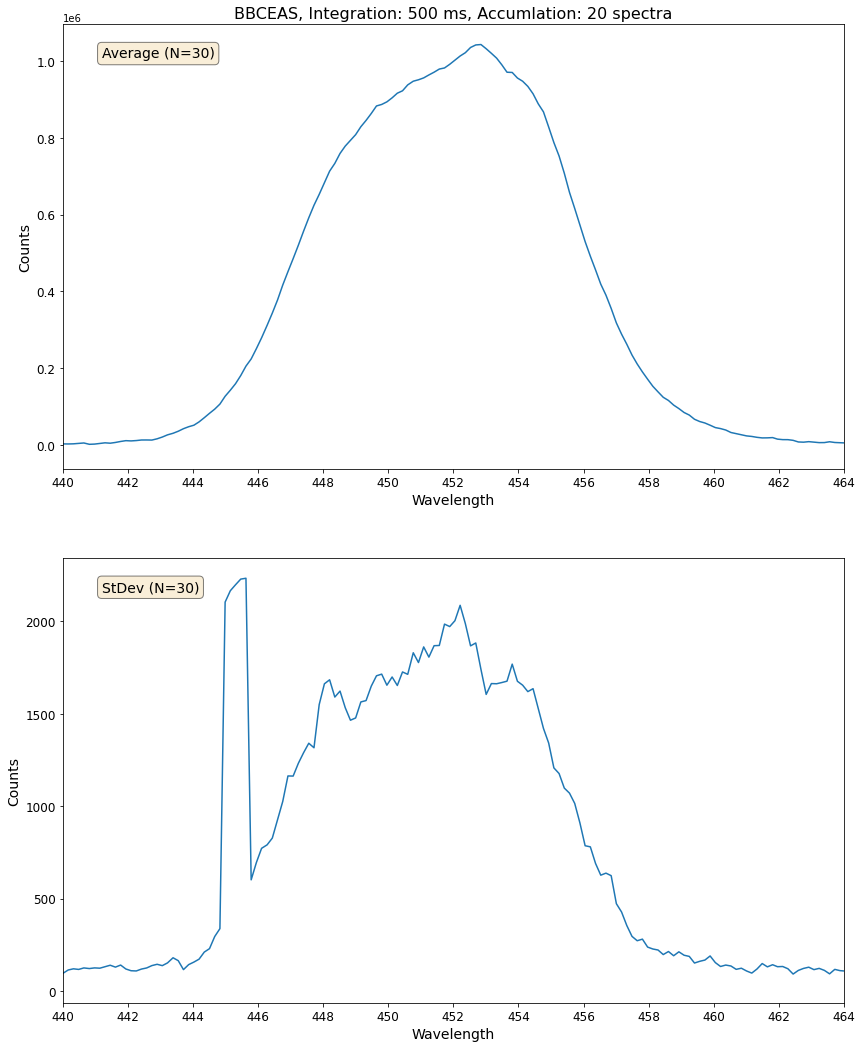

In [63]:
## Average and standard deviation of accumulations

plt.figure(figsize=(14,18)) 
spectra = SCbg1
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ceasavg=np.average(spectra[:,1:],axis=1)
ceasstd=np.std(spectra[:,1:],axis=1)

ax0 = plt.subplot(2, 1, 1) 
ax0.plot(spectra[:,0], ceasavg)

## Formatting 
ax0.set_xlim(440,464)
ax0.set_xticks(np.arange(440,466,2))
ax0.set_xlabel('Wavelength',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Counts',size=14)
ax0.set_title("BBCEAS, Integration: 500 ms, Accumlation: 20 spectra",size=16)
#ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.text(0.05, 0.95, 'Average (N=30)', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax1 = plt.subplot(2, 1, 2) 
ax1.plot(spectra[:,0], ceasstd)

## Formatting 
ax1.set_xlim(440,464)
ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
#ax1.set_title("CEAS",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)


ax1.text(0.05, 0.95, 'StDev (N=30)', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
#plt.savefig('BBCEASacc20.png')

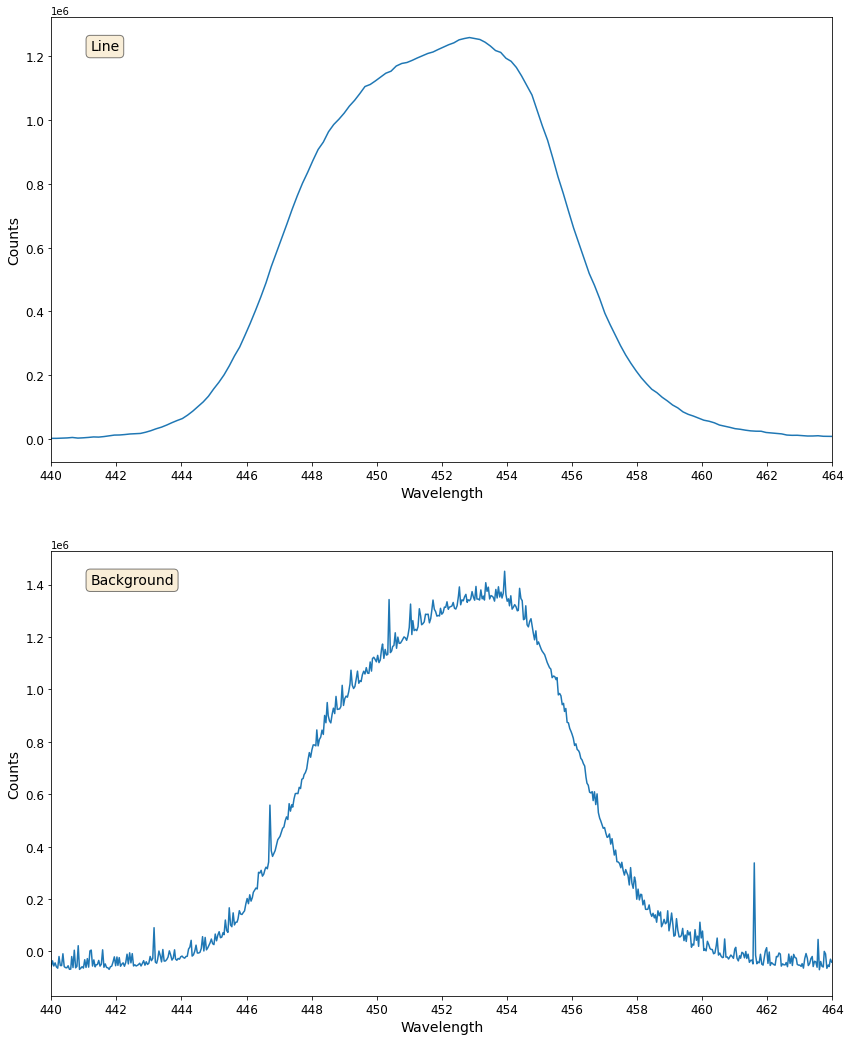

In [83]:
## Spectra comparison
plt.figure(figsize=(14,18)) 

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
x1=SCbg1[:,0]
x2=DCbg1[:,0]
y1=np.average(SCbg1[:,1:],axis=1)
y2=np.average(DCbg1[:,1:],axis=1)*40

ax0 = plt.subplot(2, 1, 1) 
ax0.plot(x1, y1)

## Formatting 
ax0.set_xlim(440,464)
ax0.set_xticks(np.arange(440,466,2))
ax0.set_xlabel('Wavelength',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Counts',size=14)
#ax0.set_title("BBCEAS, Integration: 500ms, %i Accumulations" % (samples),size=16)
#ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
ax0.text(0.05, 0.95, 'Line', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax1 = plt.subplot(2, 1, 2) 
ax1.plot(x2, y2)

## Formatting 
ax1.set_xlim(440,464)
ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
#ax1.set_title("CEAS",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
ax1.text(0.05, 0.95, 'Background', transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.savefig('BBCEASacc1.png')

In [ ]:
## Single plot spectrum
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(ceaspec[:,0], ceasstd)

ax1.set_xlim(445,445.5)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
#ax1.set_title("CEAS",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)

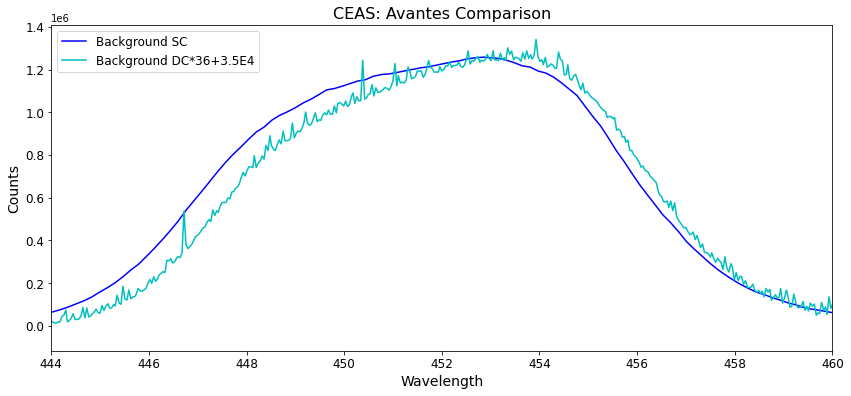

In [113]:
## Single plot spectra
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(SCbg1[:,0], np.average(SCbg1[:,1:],axis=1),'-b',label="Background SC")
ax1.plot(DCbg1[:,0], np.average(DCbg1[:,1:],axis=1)*36+.35e5,'-c',label="Background DC*36+3.5E4")
#ax1.plot(nov11ln1b[:,0], np.average(nov4ln1b[:,1:],axis=1),'-g',label="Line Nov4 (mean)")
#ax1.plot(nov11ln1b[:,0], np.average(nov11ln1b[:,1:],axis=1),'-r',label="Line Nov11 (mean)")

ax1.set_xlim(444,460)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
ax1.set_title("CEAS: Avantes Comparison",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
#plt.savefig('BBCEASmeasurements.png')

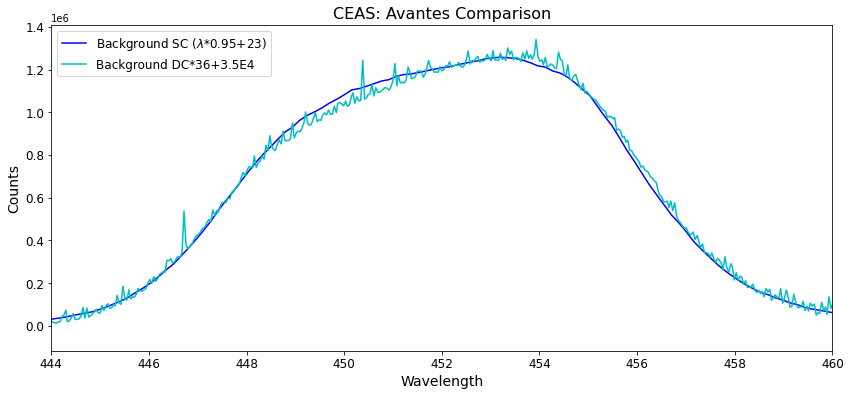

In [114]:
## Single plot spectra
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(SCbg1[:,0]*.95+23, np.average(SCbg1[:,1:],axis=1),'-b',label="Background SC ($\lambda$*0.95+23)")
ax1.plot(DCbg1[:,0], np.average(DCbg1[:,1:],axis=1)*36+.35e5,'-c',label="Background DC*36+3.5E4")
#ax1.plot(nov11ln1b[:,0], np.average(nov4ln1b[:,1:],axis=1),'-g',label="Line Nov4 (mean)")
#ax1.plot(nov11ln1b[:,0], np.average(nov11ln1b[:,1:],axis=1),'-r',label="Line Nov11 (mean)")

ax1.set_xlim(444,460)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
ax1.set_title("CEAS: Avantes Comparison",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
#plt.savefig('BBCEASmeasurements.png')

In [ ]:
## Single plot extinction

f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(line[:,0], alpha2)

ax1.set_xlim(440,460)
ax1.set_xticks(np.arange(444,458,2))
ax1.set_ylim(4e-7,9e-7)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
#ax1.set_ylabel('molecule/cm$^2$',size=14)
ax1.set_ylabel('Counts',size=14)
#ax1.set_title("CEAS",size=16)
#ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
plt.savefig('BBCEASext2.png')

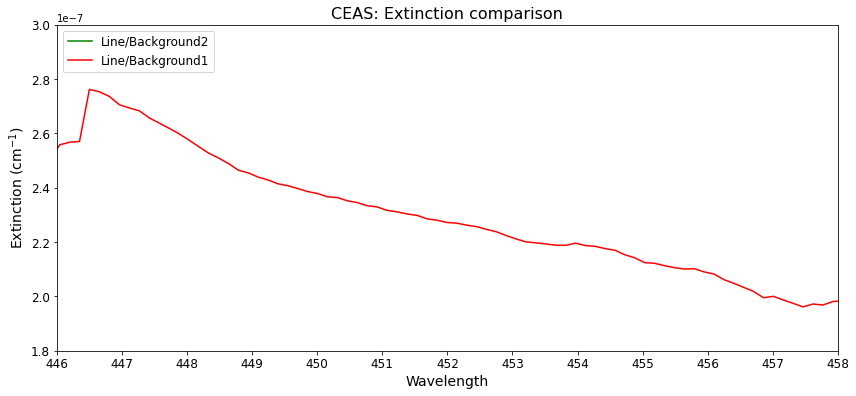

In [11]:
## Single plot extinctions

f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(line[:,0]*.95+23, alpha1,'-g',label="Line/Background2")
ax1.plot(line[:,0]*.95+23, alpha2,'-r',label="Line/Background1")

ax1.set_xlim(446,458)
ax1.set_xticks(np.arange(446,459,1))
ax1.set_ylim(1.8e-7,0.3e-6)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
ax1.set_title("CEAS: Extinction comparison",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
plt.savefig('BBCEASext_comp.png')

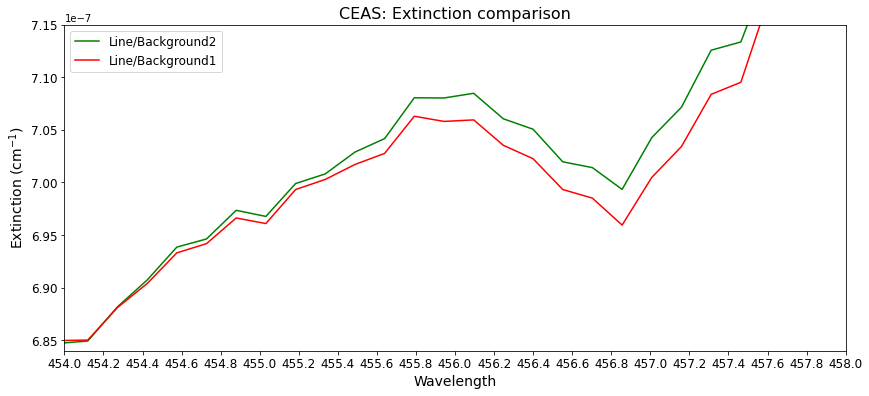

In [105]:
## Single plot extinctions

f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(line[:,0]*.95+23, alpha1,'-g',label="Line/Background2")
ax1.plot(line[:,0]*.95+23, alpha2,'-r',label="Line/Background1")

ax1.set_xlim(454,458)
ax1.set_xticks(np.arange(454,458.2,.2))
ax1.set_ylim(0.684e-6,.715e-6)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
ax1.set_title("CEAS: Extinction comparison",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
plt.savefig('BBCEASext_comp.png')

In [ ]:
## Single plot of series of extinctions


f, ax0 = plt.subplots(figsize=(14,6))

spectra1 = np.average(nov11bg2b[:,1:],axis=1)
spectra2 = nov11ln1b
cols=len(spectra2[0,:])
col = 1

while col < cols:
    ax0.plot(spectra2[:,0],extinction(spectra2[:,col],spectra1,0.99985,70))
    col = col+1

spectra1 = np.average(nov4bg2b[:,1:],axis=1)
spectra2 = nov4ln1b
cols=len(spectra2[0,:])
col = 1

while col < cols:
    ax0.plot(spectra2[:,0],extinction(spectra2[:,col],spectra1,0.99985,70))
    col = col+1    
    
## Formatting 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax0.set_ylim(4e-7,7e-7)
ax0.set_xlim(444,456)
ax0.set_xticks(np.arange(444,458,2))
ax0.set_xlabel('Wavelength',size=14)
#ax0.set_ylabel('molecule/cm$^2$',size=14)
ax0.set_ylabel('Counts',size=14)
ax0.set_title("BBCEAS Accumulations",size=16)
#ax0.legend(fontsize=12, loc='upper left')
ax0.tick_params(labelsize=12)
#ax0.text(0.05, 0.95, 'Accumulations', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)

In [18]:
### Calulations of simulated Reff 
NO2ref=np.load("NO2_avantes_interp.npy")


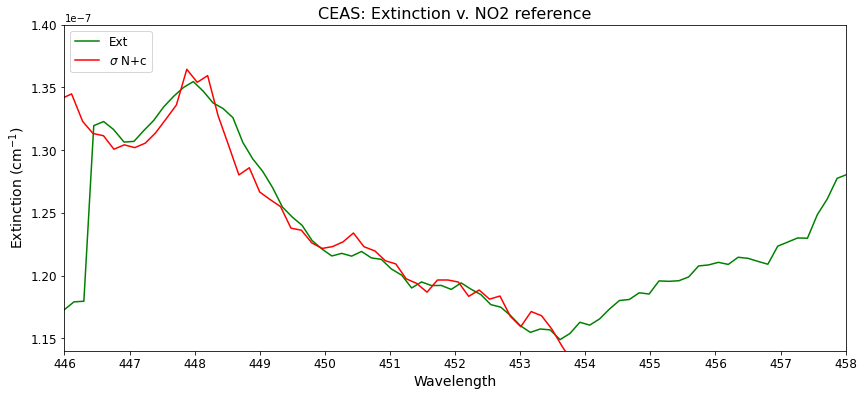

In [56]:
f, ax1 = plt.subplots(figsize=(14,6))

ax1.plot(SCln1[:,0]*.95+22.95, alpha2,'-g',label="Ext")
ax1.plot(NO2ref[:,0], NO2ref[:,1]*2.0e10-.0000000025*NO2ref[:,0]+1.240e-6,'-r',label="$\sigma$ N+c")

ax1.set_xlim(446,458)
ax1.set_xticks(np.arange(446,459,1))
ax1.set_ylim(1.14e-7,1.4e-7)
#ax1.set_xticks(np.arange(440,466,2))
ax1.set_xlabel('Wavelength',size=14)
ax1.set_ylabel('Extinction (cm$^{-1}$)',size=14)
ax1.set_title("CEAS: Extinction v. NO2 reference",size=16)
ax1.legend(fontsize=12, loc='upper left')
ax1.tick_params(labelsize=12)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax1.text(0.05, 0.95, 'N=9E10 molecule*$cm^{-3}$ (~4ppb)\n c=5.15E-7', transform=ax0.transAxes, fontsize=14,verticalalignment='top', bbox=props)
#plt.savefig('BBCEASext_v_ref.png')